# Human Activity Recognition

1.导入需要的包

In [1]:
import csv
import math
import time
import numpy as np
import pandas as pd
import copy
import scipy.signal as signal
from scipy.fftpack import fft
from scipy.signal import welch,butter,filtfilt
import matplotlib.pyplot as plt
from detecta import detect_peaks
import random
from sklearn import svm
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB

2.设定程序中需要的变量

In [2]:
f=20        # 频率（HZ）
Time=35     #时间（秒）

3.导入小程序采集的数据，并查看前五行

In [3]:
def load_csv(filename):
    file=open(filename,'r')
    dataset=[]
    csv_reader=csv.reader(file)
    for line in csv_reader:
        if not line:
            continue
        dataset.append(line)
    return dataset
filename="all.csv"
dataset=load_csv(filename)
del dataset[0]                  # 去掉表头
print(dataset[0:5])

[['0bdd6b5e5ec742880009d5b822082713', '[-0.09362574,-0.11796902,-0.13948523,-0.16017304,-0.13118406,-0.12299397,-0.13662657,-0.13281116,-0.1307464,-0.11598854,-0.11119918,-0.17954406,-0.2500533,-0.27000466,-0.3909176,-0.39978188,-0.59248835,-0.43777114,-0.41315493,-0.43755373,-0.3826825,-0.7561454,-1.2539086,-0.95460844,-0.4024107,0.14720413,0.08018852,-0.12014966,-0.23577714,-0.18847348,-0.23196273,-0.19073455,-0.21287613,-0.15409848,-0.10703327,-0.08783847,-0.13275753,-0.061032988,-0.11479814,-0.14161032,-0.1232602,-0.32700676,-0.2669851,-0.22703257,-0.15435801,-0.23183437,-0.31830242,-0.18914,-0.20294595,-0.37032747,-0.37606302,-0.37648436,-0.3783691,-0.32854673,-0.21664652,-0.03412216,-0.13830346,-0.30929255,-0.27980557,-0.2591714,-0.13398048,-0.2856455,-0.18848017,-0.13376214,-0.18152167,-0.11580658,-0.14561248,-0.116286375,-0.06927095,-0.054969918,-0.1232784,-0.08739315,0.017971836,0.0052356403,-0.141165,-0.2584378,-0.16330945,-0.07321948,-0.22675197,-0.12007018,-0.14678563,-0.20

可以发现，小程序采集的数据是字符格式，各个列变量之间没有分开，因此需要将其转化成python可以处理的列表或numpy矩阵形式。

In [4]:
for line in dataset:                                # 遍历每一个样本
    line[-1]=int(line[-1])                          # 字符串转整数
    for i in range(1,len(dataset[0])-1):              # 遍历某一个样本的每一个轴和时间戳（用line[i]表示）
        line[i]=line[i].strip("[").strip("]").split(',')           # 去掉数组类型首尾的[]并用逗号分割
        line[i]=line[i][0:f*Time]                 # 统一记录的数据长度,保证数据是等长的
        for j in range(len(line[i])):               # 遍历某个轴中的每一个数据
            line[i][j]=float(line[i][j])           # 字符串转浮点数
raw_data=list()
for i in range(len(dataset)):
    if len(dataset[i][1])>=700:
        raw_data.append(dataset[i])         # 加速度计有问题的删除整个样本

展示某一个样本的六轴数据

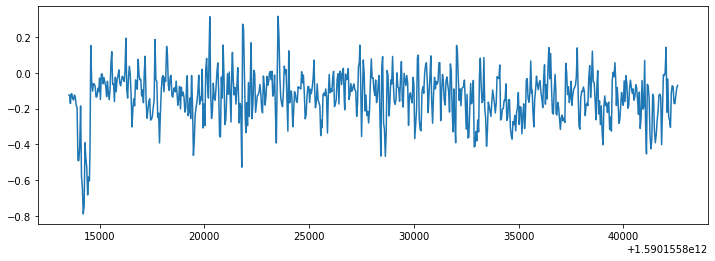

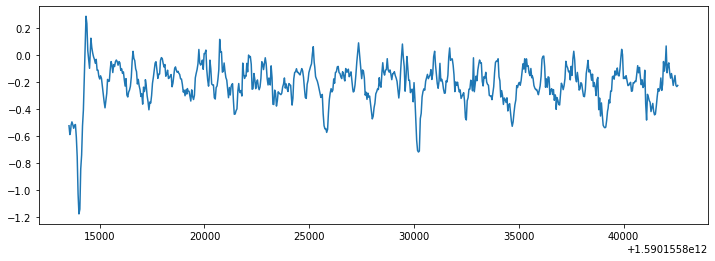

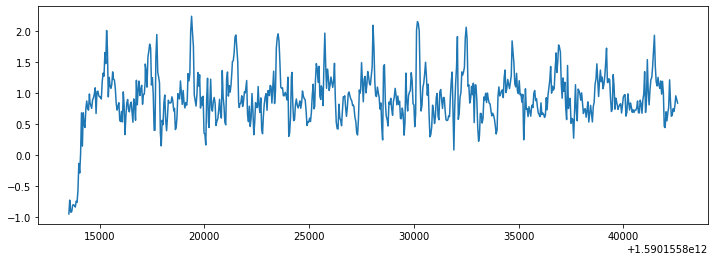

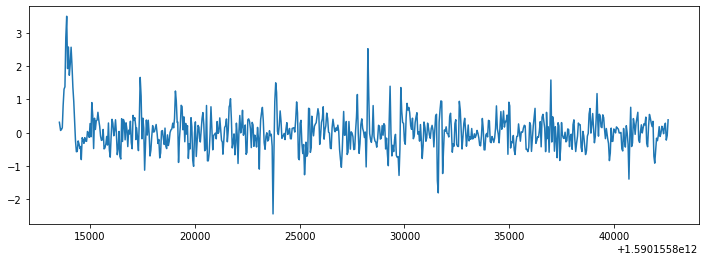

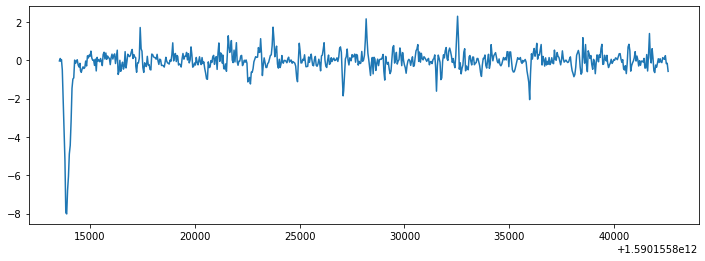

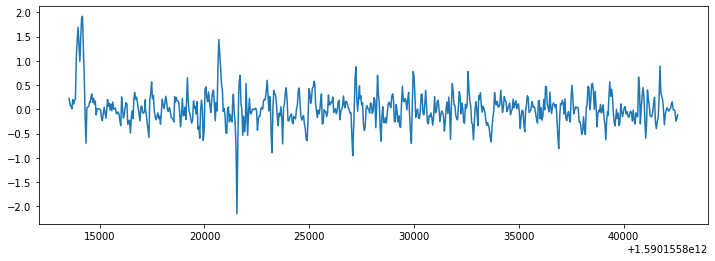

In [5]:
plt.rcParams['figure.figsize'] = (12.0, 4.0) # 设置figure_size尺寸
for i in range(6):
    plt.plot(raw_data[3][-2],raw_data[3][i+1])
    plt.show()

4.使用滤波器进行数字信号处理

- 中值滤波器：对每一个数据点，选择一个邻域，用这个邻域中的中位数代替此数据点。

In [6]:
#中值滤波
for line in raw_data:                                  # 遍历每一个样本
    for i in range(1,len(raw_data[0])-2):              # 遍历某一个样本的每一个轴（用line[i]表示）
        line[i]=signal.medfilt(line[i], 5)             # 中值滤波，第二个参数是以多少个数为邻域取中位数，必须是奇数，
                                                       # 通过试验选择最优的数值。滤波之后使尖锐的曲线变平滑。

- butterworth滤波器：设定截止频率，只允许低频信号通过

In [7]:
# butterworth滤波器
cutoff=9            # 截止频率
nyq=0.5*f           # nyquist频率（采样频率的一半）
order=5             # 滤波器阶数
n=int(Time*f)       # 每个样本采样点总数
def butter_lowpass_filter(data,cutoff,f,order):
    normal_cutoff=cutoff/nyq            # 计算增益
    b,a=butter(order,normal_cutoff,btype='low',analog=False)        # 返回butterworth滤波器的系数
    y=filtfilt(b,a,data)                                             # 使用butterworth滤波器进行信号处理
    return y
for line in raw_data:
    for i in range(1, len(raw_data[0]) - 2):
        line[i]=butter_lowpass_filter(line[i],cutoff,f,order)
    for j in range(1,4):
        line[j]=butter_lowpass_filter(line[j],0.3,f,order)

展示滤波后某一个样本的六轴图像

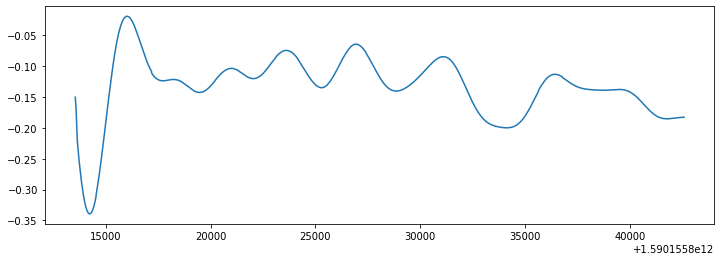

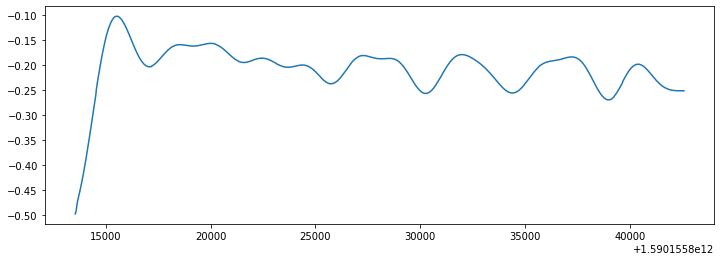

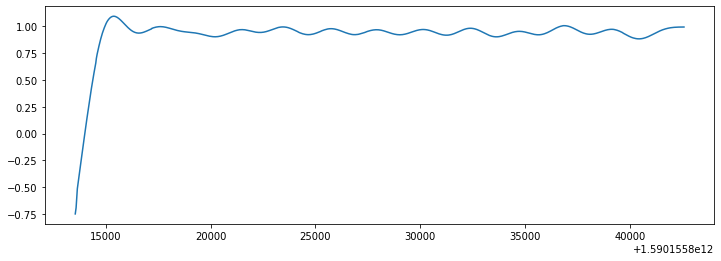

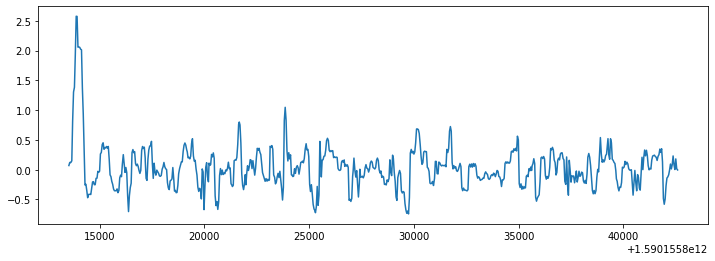

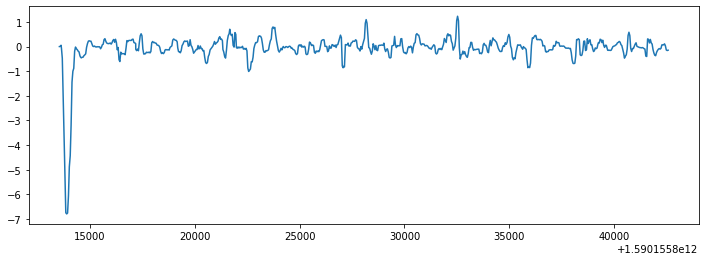

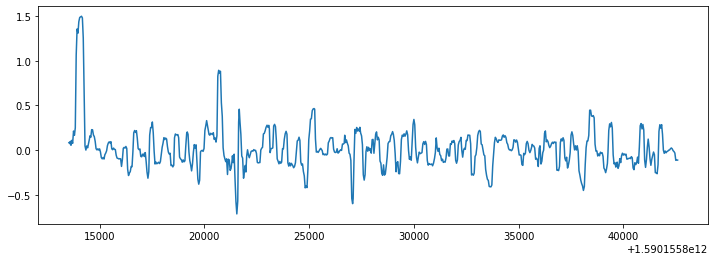

In [8]:
for i in range(6):
    plt.plot(raw_data[3][-2],raw_data[3][i+1])     
    plt.show()

5.切分数据
- 为保证窗口数据包含一个完整的动作，窗口大小设为2秒（也是不断调整，试验尝试得出的）。
- 切分数据时不可避免一个动作被阶段，设定相邻窗口的重合部分为0.5
- 对六轴和时间戳、标签进行数据切分

In [9]:
window_length=2           # 窗口大小（秒）
n_points=int(f*window_length)    # 每个窗口中数据的个数
n_windows=int(2*(Time/window_length)-1)      # 窗口个数（这个地方设计的时候保证必须是个整数）
overlap=0.5
for line in raw_data:                                # 遍历每一个样本
    for i in range(1,len(raw_data[0])-1):            # 遍历某一个样本的每一个轴和时间戳（用line[i]表示）
        segmented=list()                              # 最后用这个列表替换line[i]
        for j in range(n_windows):
            segmented.append(line[i][int(j*overlap*n_points):int(j*overlap*n_points+n_points)])
        line[i]=segmented
# dataset第一维是样本，第二维是id，三轴，时间戳，对于三轴的第三维是切割的数据array
preprocessed_data=np.array(raw_data)             # 切割后的数据转成np矩阵

6.特征提取

在将数据放入模型训练之前，需要先对原始数据进行特征提取，包括快速傅里叶变换、能量谱密度、自相关等


- 快速傅里叶变换

如果一个信号含有不同频率的周期分量，傅里叶分析可以将这个信号按照频率进行分解，傅里叶变换可以将信号从时域转换到频域

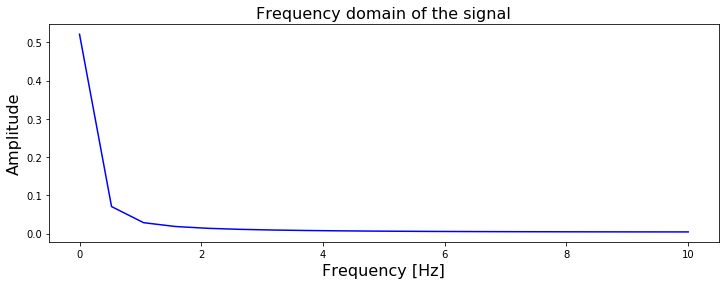

finish


In [10]:
def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)      # 从0到f/2,填充N/2个数据，即频率取了前一半
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])     # 只留下前面一半的数据
    return f_values, fft_values
data_fft=copy.deepcopy(preprocessed_data)               # 拷贝预处理数据，fft之后直接替换
f_values, fft_values = get_fft_values(dataset[0][1][0], 1/f, n_points, f)     # 对某一个accX的切割做fft
plt.plot(f_values, fft_values, linestyle='-', color='blue')
plt.xlabel('Frequency [Hz]', fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
plt.title("Frequency domain of the signal", fontsize=16)
plt.show()
print("finish")
# for i in range(len(preprocessed_data)):
#     for j in range(1, len(preprocessed_data[0]) - 1):        # 遍历某一个样本的每一个轴（用line[i]表示）
#         for k in range(n_windows):                                  # 遍历切割出来的每一组数据（用line[i][j]表示），对每一组数据做fft
#             f_values,fft_values=get_fft_values(preprocessed_data[i][j][k],1/f, n_points, f)
#             data_fft[i][j][k]=fft_values           # 直接用频域数据替换原始时域数据
# plt.plot(f_values, data_fft[0][1][0], linestyle='-', color='blue')
# plt.show()            # 和上面做了一样的图，对照一下

在上面的代码中，fft函数返回的是一个复数，实部是幅度，虚部是相位角，由于我们关心的是幅度，所以用np.abs获取实部。

同时，根据nyqust采样定理，采样频率高于实际频率的两本，因此实际只有fft返回的前一半的数据是有意义的。

- 能量谱密度（PSD）
能量谱密度与傅里叶变换相似，都是描述了信号的频谱，但是除此之外，它还包括了信号能量的分布

D:\anaconda3\envs\python36\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 40, using nperseg = 40
  .format(nperseg, input_length))


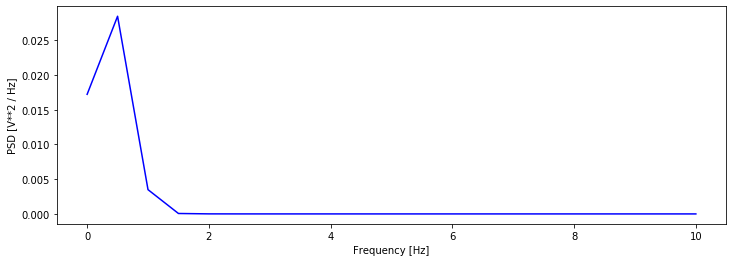

In [11]:
def get_psd_values(y_values,f_s):
    f_values, psd_values = welch(y_values, fs=f_s)              # 返回的数组长度是26，我也不知道为啥
    return f_values, psd_values
data_psd=copy.deepcopy(preprocessed_data)
f_values, psd_values = get_psd_values(dataset[5][1][0],f)               # 对第一个accX的切割做psd
plt.plot(f_values, psd_values, linestyle='-', color='blue')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [V**2 / Hz]')
plt.show()
# for i in range(len(preprocessed_data)):
#     for j in range(1, len(preprocessed_data[0]) - 1):        # 遍历某一个样本的每一个轴（用line[i]表示）
#         for k in range(n_windows):                                  # 遍历切割出来的每一组数据（用line[i][j]表示），对每一组数据做fft
#             f_values,psd_values=get_psd_values(preprocessed_data[i][j][k], f)
#             data_psd[i][j][k]=psd_values           # 直接用频域数据替换原始时域数据
# plt.plot(f_values, data_psd[0][1][0], linestyle='-', color='blue')
# plt.show()            # 和上面做了一样的图，对照一下

- 自相关
自相关计算了一个信号和自己本身在时间延迟上的相关性，如果一个信号与延迟时间t后有很强的相关性，那么该信号很可能是周期信号

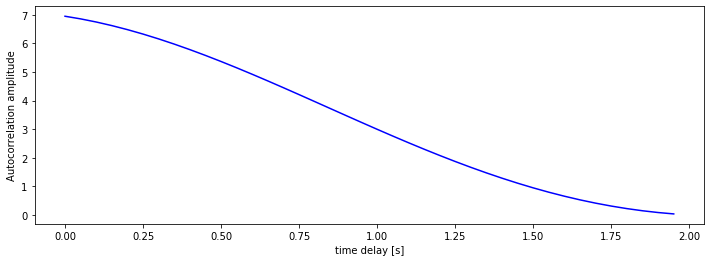

In [12]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[len(result)//2:]
def get_autocorr_values(y_values, T, N):
    autocorr_values = autocorr(y_values)
    x_values = np.array([T * jj for jj in range(0, N)])
    return x_values, autocorr_values
data_autocorr=copy.deepcopy(preprocessed_data)
t_values, autocorr_values = get_autocorr_values(dataset[4][1][0], 1/f, n_points)            # 对第一个accX的切割做自相关
plt.plot(t_values, autocorr_values, linestyle='-', color='blue')
plt.xlabel('time delay [s]')
plt.ylabel('Autocorrelation amplitude')
plt.show()
# for i in range(len(preprocessed_data)):
#     for j in range(1, len(preprocessed_data[0]) - 1):        # 遍历某一个样本的每一个轴（用line[i]表示）
#         for k in range(n_windows):                                  # 遍历切割出来的每一组数据（用line[i][j]表示），对每一组数据做fft
#             t_values,autocorr_values=get_autocorr_values(preprocessed_data[i][j][k], 1/f,n_points)
#             data_autocorr[i][j][k]=autocorr_values           # 直接用频域数据替换原始时域数据
# plt.plot(t_values, data_autocorr[4][-2][0], linestyle='-', color='blue')
# plt.show()            # 和上面做了一样的图，对照一下

- 综合上述过程，进行特征提取

当我们将时域数据转换到频域数据上之后，便可以提取特征，使用分类器进行建模。提取特征的常用方法可以是信号的频率分量以及在此分量上的振幅。

In [13]:
def get_first_n_peaks(x,y,n_peaks=5):          # 输入峰值数组，返回前n（=5）个峰值的数组
    if len(x)>=n_peaks:
        return x[0:n_peaks],y[0:n_peaks]
    else:
        missing_peaks=n_peaks-len(x)
        x=np.concatenate((x,[0]*missing_peaks))
        y=np.concatenate((y,[0]*missing_peaks))
        return x,y
def get_features(x_values,y_values,mph):            # 输入x和y数据，找到y峰值高于mph的前5个的x和y，返回
    indices_peaks = detect_peaks(y_values, mph=mph)
    peaks_x, peaks_y = get_first_n_peaks(x_values[indices_peaks], y_values[indices_peaks])
    return np.concatenate((peaks_x , peaks_y))                    # 列表相加得到一个合并的同维列表，峰值的横坐标在前，纵坐标在后，共10个元素
def extract_features_labels(preprocessed_data,f,n_points):
    features_matrix=[]
    labels_matrix=[]
    percentile=5
    denominator=10
    for i in range(len(preprocessed_data)):        # 遍历每一个人
        for k in range(n_windows):                 # 遍历切割出来的每一组数据（用preprocessed_data[i][j][k]表示），对每一组数据做fft,psd,autocorr
            features = []                          # 对每一组分割数据提取所有轴生成features
            labels_matrix.append(preprocessed_data[i][-1])  # 假设每一行最后一个数据是类别标签
            for j in range(1, len(preprocessed_data[0]) - 2):  # 遍历某一个人的每一个轴（用preprocessed_data[i][j]表示）
                signal_min=np.nanpercentile(preprocessed_data[i][j][k],percentile)
                signal_max=np.nanpercentile(preprocessed_data[i][j][k],100-percentile)      # 求min，max
                mph=signal_min+(signal_max-signal_min)/denominator          # 设定mph
                # 傅里叶变换
                f_values, fft_values = get_fft_values(preprocessed_data[i][j][k], 1 / f, n_points, f)
                data_fft[i][j][k] = fft_values  # 直接用频域数据替换原始时域数据
                features.append(get_features(f_values,fft_values,mph))         # 直接放到features列表里
                # 能量谱密度
                f_values, psd_values = get_psd_values(preprocessed_data[i][j][k], f)
                data_psd[i][j][k] = psd_values  # 直接用频域数据替换原始时域数据
                features.append(get_features(f_values, psd_values, mph))  # 直接放到features列表里
                # 自相关
                t_values, autocorr_values = get_autocorr_values(preprocessed_data[i][j][k], 1 / f, n_points)
                data_autocorr[i][j][k] = autocorr_values  # 直接用频域数据替换原始时域数据
                features.append(get_features(t_values, autocorr_values, mph))  # 直接放到features列表里（features是列表，里面的元素是array）
            features=np.array(features).flatten()           # features变成array，元素是float
            features_matrix.append(features)
    return labels_matrix,features_matrix
# 特征提取之后的数据集
labels_matrix,features_matrix=extract_features_labels(preprocessed_data,f,n_points)
labels_matrix=np.array([labels_matrix])
features_matrix=np.array(features_matrix)
together=np.concatenate((features_matrix,labels_matrix.transpose()),axis=1)

D:\anaconda3\envs\python36\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 40, using nperseg = 40
  .format(nperseg, input_length))


In [14]:
random.seed(1)
random.shuffle(together)
X_train,Y_train=list(),list()
X_test,Y_test=list(),list()
for i in range(int(len(together)*0.7)):
    X_train.append(together[i][0:len(together[0])-1])
    Y_train.append(together[i][-1])
for i in range(int(len(together)*0.7),len(together)):
    X_test.append(together[i][0:len(together[0])-1])
    Y_test.append(together[i][-1])
clf=RandomForestClassifier(n_estimators=1000)
clf.fit(X_train, Y_train)
print("Accuracy on training set is : {}".format(clf.score(X_train, Y_train)))
print("Accuracy on test set is : {}".format(clf.score(X_test, Y_test)))
Y_test_pred = clf.predict(X_test)
print(classification_report(Y_test, Y_test_pred))

Accuracy on training set is : 1.0
Accuracy on test set is : 0.8349875930521092
              precision    recall  f1-score   support

         1.0       0.72      0.94      0.81       226
         2.0       0.93      0.80      0.86       283
         3.0       0.00      0.00      0.00        62
         4.0       0.88      1.00      0.93       235

    accuracy                           0.83       806
   macro avg       0.63      0.68      0.65       806
weighted avg       0.78      0.83      0.80       806



D:\anaconda3\envs\python36\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7.模型选择

  首先为不同的模型构建字典，便于遍历模型并输出查看结果

In [15]:
dict_classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Nearest Neighbors": KNeighborsClassifier(),
    "Linear SVM": SVC(),
    "Gradient Boosting Classifier": GradientBoostingClassifier(n_estimators=1000),
    "Decision Tree": tree.DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=1000),
    "Neural Net": MLPClassifier(alpha = 1),
    "Naive Bayes": GaussianNB(),
    #"AdaBoost": AdaBoostClassifier(),
    #"QDA": QuadraticDiscriminantAnalysis(),
    #"Gaussian Process": GaussianProcessClassifier()
}

 然后，我们可以在此字典和每个分类器上迭代：

- 训练分类器.fit(X_train, Y_train)
- 评估分类器在训练集中的性能.score(X_train, Y_train)
- 评估分类器在测试集上的性能.score(X_test, Y_test)
- 记录训练分类器所需的时间。
- 将训练模型、训练分数、测试分数和训练时间保存到字典中。如有必要，此字典可以使用 Python 的pickle模块保存。

In [16]:
def batch_classify(X_train, Y_train, X_test, Y_test, no_classifiers = 5, verbose = True):    
    dict_models = {}
    for classifier_name, classifier in list(dict_classifiers.items())[:no_classifiers]:
        t_start = time.clock()
        classifier.fit(X_train, Y_train)
        t_end = time.clock()
        
        t_diff = t_end - t_start
        train_score = classifier.score(X_train, Y_train)
        test_score = classifier.score(X_test, Y_test)
        
        dict_models[classifier_name] = {'model': classifier, 'train_score': train_score, 'test_score': test_score, 'train_time': t_diff}
        if verbose:
            print("trained {c} in {f:.2f} s".format(c=classifier_name, f=t_diff))
    return dict_models



def display_dict_models(dict_models, sort_by='test_score'):
    cls = [key for key in dict_models.keys()]
    test_s = [dict_models[key]['test_score'] for key in cls]
    training_s = [dict_models[key]['train_score'] for key in cls]
    training_t = [dict_models[key]['train_time'] for key in cls]
    
    df_ = pd.DataFrame(data=np.zeros(shape=(len(cls),4)), columns = ['classifier', 'train_score', 'test_score', 'train_time'])
    for ii in range(0,len(cls)):
        df_.loc[ii, 'classifier'] = cls[ii]
        df_.loc[ii, 'train_score'] = training_s[ii]
        df_.loc[ii, 'test_score'] = test_s[ii]
        df_.loc[ii, 'train_time'] = training_t[ii]
    
    print(df_.sort_values(by=sort_by, ascending=False))

展示结果

In [17]:
dict_models = batch_classify(X_train, Y_train, X_test, Y_test, no_classifiers = 8)
display_dict_models(dict_models)

D:\anaconda3\envs\python36\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


trained Logistic Regression in 0.84 s
trained Nearest Neighbors in 0.11 s
trained Linear SVM in 1.14 s
trained Gradient Boosting Classifier in 88.96 s
trained Decision Tree in 0.13 s
trained Random Forest in 6.48 s
trained Neural Net in 4.37 s
trained Naive Bayes in 0.02 s
                     classifier  train_score  test_score  train_time
3  Gradient Boosting Classifier     1.000000    0.856079   88.964982
6                    Neural Net     0.994681    0.852357    4.373644
5                 Random Forest     1.000000    0.834988    6.484375
4                 Decision Tree     1.000000    0.822581    0.134295
0           Logistic Regression     0.962766    0.794045    0.840673
7                   Naive Bayes     0.852128    0.709677    0.022193
1             Nearest Neighbors     0.924468    0.688586    0.113169
2                    Linear SVM     0.790426    0.576923    1.144951


可以发现，Gradient Boosting算法效果是最好的，同时训练时间也最长，接近40秒；表现最不好的是SVM；训练时间最短的是Native Bayes。

8.超参数调优

通过模型的训练与对比，结合我们自身的需求，选择最为合适的模型进行参数调优。

由于后期需要部署JS，因此需要在算法的复杂程度和准确率之间取舍，此处我选择MLP作为最终的模型。

In [18]:
MLP_params={
    'alpha':[0.1,0.5,1],
    'activation':['tanh','identity','relu','logistic'],
    'hidden_layer':[80,100,150]
}
for alpha in MLP_params['alpha']:
    for activation in MLP_params['activation']:
        for hidden_layer in MLP_params['hidden_layer']:
            clf=MLPClassifier(activation=activation,alpha=alpha,hidden_layer_sizes=(hidden_layer,))
            clf.fit(X_train, Y_train)
            train_score = clf.score(X_train, Y_train)
            test_score = clf.score(X_test, Y_test)
            print("For ({}, {}, {}) - train, test score: \t {:.5f} \t-\t {:.5f}".format(alpha, activation, hidden_layer, train_score, test_score))

D:\anaconda3\envs\python36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\anaconda3\envs\python36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\anaconda3\envs\python36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\anaconda3\envs\python36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_it

For (0.1, tanh, 80) - train, test score: 	 0.99947 	-	 0.84367
For (0.1, tanh, 100) - train, test score: 	 1.00000 	-	 0.82506
For (0.1, tanh, 150) - train, test score: 	 1.00000 	-	 0.85112
For (0.1, identity, 80) - train, test score: 	 0.97553 	-	 0.83127
For (0.1, identity, 100) - train, test score: 	 0.97021 	-	 0.80397
For (0.1, identity, 150) - train, test score: 	 0.96543 	-	 0.81886
For (0.1, relu, 80) - train, test score: 	 0.99947 	-	 0.83251
For (0.1, relu, 100) - train, test score: 	 0.99947 	-	 0.82506
For (0.1, relu, 150) - train, test score: 	 1.00000 	-	 0.83747
For (0.1, logistic, 80) - train, test score: 	 0.99309 	-	 0.84367
For (0.1, logistic, 100) - train, test score: 	 0.99309 	-	 0.83623
For (0.1, logistic, 150) - train, test score: 	 0.99574 	-	 0.84615
For (0.5, tanh, 80) - train, test score: 	 0.99681 	-	 0.82878
For (0.5, tanh, 100) - train, test score: 	 0.99840 	-	 0.83871
For (0.5, tanh, 150) - train, test score: 	 0.99681 	-	 0.83623
For (0.5, identity, 8

可以看出，当激活函数relu，alpha=1，隐藏层神经元个数为100时，MLP模型表现是最好的；同时relu函数运算较快，100个神经元大小适中，用来部署JS较为合适。

保存模型

将隐藏层和输出层的权重矩阵及偏置矩阵保存到CSV文件中。

In [19]:
clf=MLPClassifier(activation='logistic',alpha=0.1,hidden_layer_sizes=(100,))
clf.fit(X_train, Y_train)
weight=clf.coefs_           # 获得MLP的权重矩阵
bias=clf.intercepts_        # 获得MLP的偏置向量
for i in range(len(weight)):
    weight[i] = weight[i].transpose()               # 权重矩阵转置方便做乘法
# print("weight:",weight)
# print("bias:",bias)
pd.DataFrame(data=weight[0]).to_csv('hidden.csv',encoding='gbk')        # 保存到csv文件
pd.DataFrame(data=weight[1]).to_csv('output.csv',encoding='gbk')
pd.DataFrame(data=bias[0]).to_csv('hidden_bias.csv',encoding='gbk')
pd.DataFrame(data=bias[1]).to_csv('output_bias.csv',encoding='gbk')


D:\anaconda3\envs\python36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
